In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
 
pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x) 

In [2]:
train_df = pd.read_csv('./data/train_data_1120.csv')
test_df = pd.read_csv('./data/test_data_1120.csv')
print(train_df.shape)
print(test_df.shape)

(4206064, 24)
(192000, 23)


In [3]:
train_df.columns

Index(['Unnamed: 0', 'poi_id', 'request_id', 'uuid', 'request_cate_id',
       'device_type', 'gender', 'job', 'cate_level1', 'cate_level2',
       'cate_level3', 'area_id', 'latitude_req', 'longitude_req', 'age',
       'avg_price', 'poi_star', 'longitude_poi', 'latitude_poi', 'distance',
       'poi_cnt_deal', 'poi_avg_discount', 'request_time_second', 'action'],
      dtype='object')

In [14]:
test_df.columns

Index(['poi_id', 'request_cate_id', 'device_type', 'gender', 'job',
       'cate_level1', 'cate_level2', 'cate_level3', 'area_id', 'latitude_req',
       'longitude_req', 'age', 'avg_price', 'poi_star', 'longitude_poi',
       'latitude_poi', 'distance', 'poi_avg_discount', 'request_time_second'],
      dtype='object')

In [5]:
train_target = train_df['action']
test_id = test_df['Unnamed: 0']

In [6]:
#train_df.drop(['action'], axis = 1, inplace=True)
train_df.drop(['action','Unnamed: 0', 'request_id', 'uuid'], axis = 1, inplace=True)
test_df.drop(['Unnamed: 0', 'request_id', 'uuid'], axis = 1, inplace=True)

In [9]:
train_df.drop(['poi_cnt_deal'], axis = 1, inplace=True)
test_df.drop(['poi_cnt_deal'], axis = 1, inplace=True)

In [15]:
n_splits = 5
random_state = 2000
# np.random.seed(random_state)
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(train_df, train_target))

cols = list(train_df.columns)
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [11]:
train_target.value_counts(0)

0    4106529
1      99535
Name: action, dtype: int64

In [16]:
xgb_param = {
    "objective" : "binary:logistic",
    "eval_metric" : "auc",
    "max_depth" : 7,
    "learning_rate" : 0.1,
    "bagging_seed" : random_state,
    "seed": random_state,
    'gpu_id':0,
    'tree_method': 'gpu_hist',
    'min_child_weight': 80
}
test_data_M = xgb.DMatrix(test_df, feature_names=cols)

for i, (train_idx, valid_idx) in enumerate(splits):
    print('Folder', i)
    x_tr, y_tr = train_df.iloc[train_idx], train_target.iloc[train_idx]
    x_valid, y_valid = train_df.iloc[valid_idx], train_target.iloc[valid_idx]
    
    train_data = xgb.DMatrix(x_tr, label=y_tr, feature_names=cols)
    valid_data = xgb.DMatrix(x_valid, label=y_valid, feature_names=cols)
    
    num_round = 100000
   
    clf = xgb.train(xgb_param, train_data, num_round, [(valid_data, 'eval')], early_stopping_rounds=2000, verbose_eval=1000)
    
    print(f'best score {clf.best_score}')
    print(f'best_iteration {clf.best_iteration}')
    
    oof[valid_idx] = clf.predict(valid_data, ntree_limit=clf.best_ntree_limit)
    predictions += clf.predict(test_data_M, ntree_limit=clf.best_ntree_limit) / n_splits
    
    del x_tr
    del y_tr

print(metrics.roc_auc_score(train_target.values, oof))

Folder 0


/home/yj/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-auc:0.623921
Will train until eval-auc hasn't improved in 2000 rounds.
[1000]	eval-auc:0.644025
[2000]	eval-auc:0.638618
Stopping. Best iteration:
[280]	eval-auc:0.646969

best score 0.646969
best_iteration 280
Folder 1
[0]	eval-auc:0.621777
Will train until eval-auc hasn't improved in 2000 rounds.
[1000]	eval-auc:0.642543
[2000]	eval-auc:0.637023
Stopping. Best iteration:
[317]	eval-auc:0.645915

best score 0.645915
best_iteration 317
Folder 2
[0]	eval-auc:0.624364
Will train until eval-auc hasn't improved in 2000 rounds.
[1000]	eval-auc:0.645467
[2000]	eval-auc:0.6405
Stopping. Best iteration:
[338]	eval-auc:0.649192

best score 0.649192
best_iteration 338
Folder 3
[0]	eval-auc:0.623413
Will train until eval-auc hasn't improved in 2000 rounds.
[1000]	eval-auc:0.646057
[2000]	eval-auc:0.639528
Stopping. Best iteration:
[390]	eval-auc:0.649307

best score 0.649307
best_iteration 390
Folder 4
[0]	eval-auc:0.621258
Will train until eval-auc hasn't improved in 2000 rounds.
[1000]

In [17]:
submission = pd.DataFrame({'ID': test_id, 'action': predictions})
oof = pd.DataFrame({'action': oof})

In [19]:
submission.to_csv('result/xgboost_oof_test_64752.csv', index = False)

In [20]:
oof.to_csv('result/xgboost_oof_train_64752.csv')

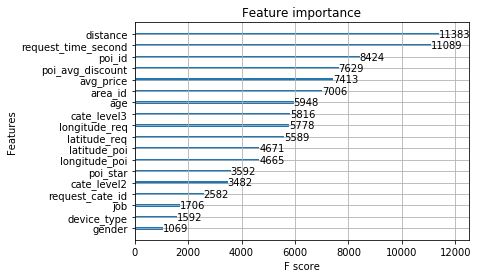

In [22]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(clf)
pyplot.show()

In [35]:
submission.shape

(192000, 2)

In [36]:
submission.describe()

,ID,action
count,192000.00000,192000.00000
mean,95999.50000,0.02244
std,55425.77018,0.01110
min,0.00000,0.00172
25%,47999.75000,0.01491
50%,95999.50000,0.02121
75%,143999.25000,0.02844
max,191999.00000,0.17952


In [37]:
submission.isnull().sum()

ID        0
action    0
dtype: int64